# 16 Land cover statistics

## About the data

In this lesson we will use two datasets.

The first one is [GAP/LANDFIRE National Terrestrial Ecosystems data for 2011 @davidson_gaplandfire_2016](https://www.sciencebase.gov/catalog/item/573cc51be4b0dae0d5e4b0c5), from the [US Geological Survey (USGS)](https://www.usgs.gov). This is a categorical raster with a 30 m x 30 m pixel resolution representing highly thematically detailed land cover map of the U.S. We will access this data through the [Microsoft Planetary Computer (MPC) data catalog](https://planetarycomputer.microsoft.com/dataset/gap). The class names and corresponding codes have been saved to a separete CSV to simplify access in this lesson. Further information on how to access the classes directly from the data are available in the [MPC catalog](https://planetarycomputer.microsoft.com/dataset/gap#Example-Notebook).


The second dataset is a shapefile with the perimeters for 2017 California fires. This data was extracted from the CALFIRE's [Historical Wildland Fire Perimeters](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all/about).

## Import auxiliary geometries

Let's start by importing the necessary libraries:

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image 

Then import and select the Thomas Fire within the fire perimeters data:

<Axes: >

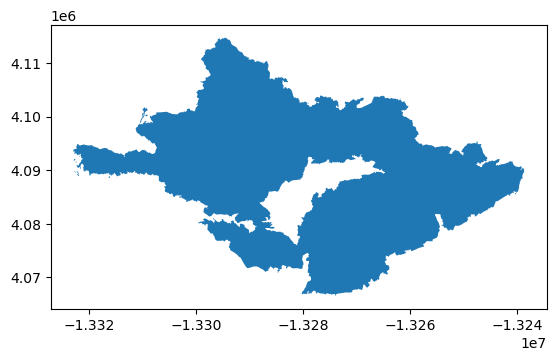

In [2]:
# set up root file path
root = os.path.join('/','courses','EDS220','data')

# import fire perimeters shapefile
fire_perimeters = gpd.read_file(os.path.join(root,
                  'California_Fire_Perimeters_2017',
                  'California_Fire_Perimeters_2017.shp'
                 ))
thomas_fire = fire_perimeters[fire_perimeters['FIRE_NAME']=='THOMAS']

# Examine fire perimeter data
thomas_fire.crs
thomas_fire.plot()

And import the CA state perimeter:

<Axes: >

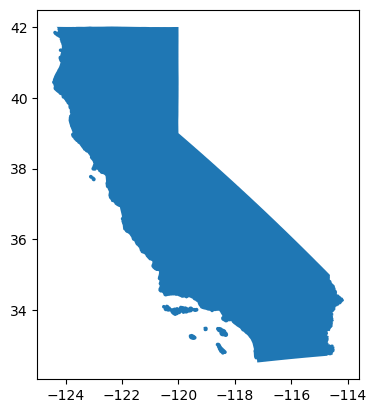

In [3]:
ca = gpd.read_file(os.path.join(root,
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))
ca.plot()

## Catalog search

Our goal is to retrieve the National Terrestrial Ecosystems data over the fire perimeter. In the [last lesson](/book/chapters/lesson-16-STAC.qmd) we used GeoJSON-type dictionary to do the catalog search. Here we will use a list `[xmin, ymin, xmax, ymax]` with the coordinate values defining the four corners of the region we want to search data over. Just as the GeoJSON, these coordinates have to be in the **EPSG:4326 CRS**. 

Our bounding box will come from the Thomas Fire perimeter. Notice we use method chaining to reproject and extract the bounds using  `total_bounds`

In [5]:
# Create bounding box for search based on extent of thomas fire object bounds using `total_bounds()`

thomas_fire_bbox = list(thomas_fire.to_crs('epsg: 4326').total_bounds)

Next, we connect to the Microsoft Planetary Computer data catalog and perform the search. The collection ID for the National Terrestrial Ecosystems data is `gap`:

In [6]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [8]:
# search MPC catalog using `search` on collections

search = catalog.search(collections = ['gap'],
                       bbox = thomas_fire_bbox)

search

In [12]:
# Retreive items from the search and get the length of the items
items = search.item_collection()
items

### The items have assets which are URLS to the actual data

In [13]:
print(f"Returned {len(items)} Items")

Returned 1 Items


## There is a single item in the search so lets go ahead and seleect it and view its prerendered image

In [14]:
# Select unique item in search

item = items[0]

### The items have assets which are URLS to the actual data (stored as a dictionary)
#### Check out the rendered preview

In [19]:
# Display pre-rendered image
# Image()
item.assets['rendered_preview'].href

# View the rendered preview image
Image(url = item.assets['rendered_preview'].href, width = 800)

In [22]:
labels = pd.read_csv(os.path.join(root, 'GAP_National_Terrestrial_Ecosystems.csv'))

labels.head()

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4


In [23]:
os.path.join(root, 'GAP_National_Terrestrial_Ecosystems.csv')

'/courses/EDS220/data/GAP_National_Terrestrial_Ecosystems.csv'

### Explore the raster:

First, open it:

- access link to data via the data url

In [25]:
lulc = rioxr.open_rasterio(item.assets['data'].href)
lulc

<xarray.DataArray (band: 1, y: 10000, x: 10000)> Size: 200MB
[100000000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB -2.361e+06 -2.361e+06 ... -2.061e+06
  * y            (y) float64 80kB 1.762e+06 1.762e+06 ... 1.462e+06 1.462e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

In [26]:
# Remove length 1 dimension
lulc = lulc.squeeze().drop_vars('band')
print('Sizes of dimensions: ', dict(lulc.sizes))

Sizes of dimensions:  {'y': 10000, 'x': 10000}


Look at how this raster is located with respect to the Thomas Fire perimeter and the CA state boundary:


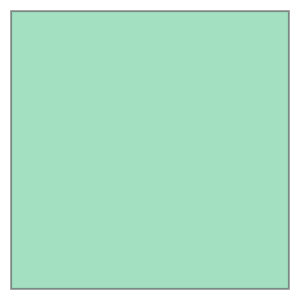

In [28]:
# start with raster and get bounds
# use shapely package to construct polygon out of four numbers
box(*lulc.rio.bounds())

In [30]:
# construct the bounding box as a geopandas df
lulc_bbox = gpd.GeoDataFrame(geometry = [box(*lulc.rio.bounds())],
                             crs = lulc.rio.crs)

In [31]:
lulc_bbox

,geometry
0,"POLYGON ((-2061135.000 1462215.000, -2061135.0..."


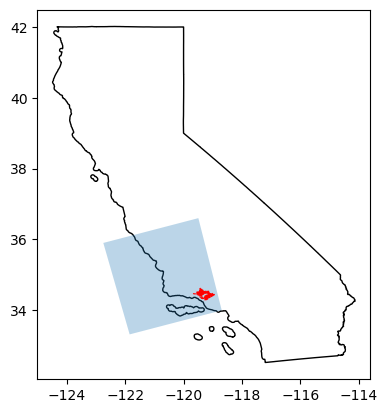

In [33]:
# Plot the raster boundary, fire perimeter, CA boundary
fig, ax = plt.subplots()
ca.plot(ax = ax, color = 'white', edgecolor = 'black')

# Reproject lulc_bbox and fire perimeter to CA CRS

lulc_bbox.to_crs(ca.crs).plot(ax=ax, alpha = 0.3)
thomas_fire.to_crs(ca.crs).plot(ax=ax, color = 'red')

plt.show()

## Clip Raster to fire bounds

This fire perimeter is complicated so if we try to clip directly, the raster will likely crash because of the detailed geometry

Instead we will do this 2 step process:
1) clip the raster using the fire perimeter **bounding box** `rio.clip_box()`
2) clip the simplified raster to the fire perimeter using `rio.clip()`

In [34]:
# Match CRS and verify update
thomas_fire_match = thomas_fire.to_crs(lulc.rio.crs)
assert thomas_fire_match.crs == lulc.rio.crs

In [35]:
# Step 1: Clip large raster to detailed geometry in two steps
# the * unpacks the items from the list to fit what the bbounds is looking for
lulc_step1 = lulc.rio.clip_box(*thomas_fire_match.total_bounds)

In [39]:
# Step 2: clip the simplified raster to the fire perimeter using rio.clip
lulc_step2 = lulc.rio.clip(thomas_fire_match.geometry)

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


*This returns a warning for a "cast" when you are converting a data value into something else - something didn't go well for it here!*

This is about Raster no-data values
After some investigation... we found out that this happens in `rio.clip()` because this function tries to replace the values outside the fire perimeter with `np.nan`

the np.nan is a `uint16` type object, when you clip, the raster wants to introduce NANs which conflicts with the type. Which brings up the casting issue

To make sure the clipping operator fills in any pixels with the adequate no-data value, we can manually set it:

In [48]:
print('Original no-data value: ', lulc.rio.nodata)

# update rasters no data value
lulc = lulc.rio.write_nodata(0)

Original no-data value:  64537


In [52]:
lulc_clip = (lulc.rio.clip_box(*thomas_fire_match.total_bounds)
                 .rio.clip(thomas_fire_match.geometry)
                 )

In [ ]:
lulc.dtype

In [49]:
print('Updated no-data value: ', lulc.rio.nodata)

Updated no-data value:  0


Use the numpy function np.unique() to get the number of pixels per class in lulc_clip. HINT: check the np.unique() documentation to see what the return_counts parameter does and read the last example.

In [57]:
values, counts = np.unique(lulc_clip, return_counts=True)

values

array([  0,  39,  40,  41,  42,  43,  45,  55, 159, 162, 165, 183, 277,
       278, 282, 296, 297, 300, 302, 303, 304, 305, 359, 360, 383, 385,
       432, 470, 472, 485, 489, 516, 539, 540, 547, 552, 553, 556, 557,
       558, 567, 568, 578, 579, 581, 582, 583, 584], dtype=uint16)

In [58]:
counts

array([1927850,    6856,     361,  133707,    3639,   23148,    2907,
          4974,    3727,   60203,    5102,   75924,     378,   11098,
            29,      98,   64073,   69702,  183963,  454498,   88503,
           799,     750,     684,      28,      90,     865,     262,
          1329,      54,      44,      27,     298,      24,      15,
            43,       7,   19000,    2181,     485,      13,      20,
            10,    1856,   40658,    3782,     830,      58])

Create a data frame pix_counts with two columns: column one must be the code numbers for the pixels in lulc_clip and column two must be the number of pixels corresponding to each code. HINT: check our class notes on pandas.DataFrames

In [61]:
pix_counts = pd.DataFrame({'counts': counts, 'values': values})

In [62]:
pix_counts

,counts,values
0,1927850,0
1,6856,39
2,361,40
3,133707,41
4,3639,42
5,23148,43
6,2907,45
7,4974,55
8,3727,159
9,60203,162


NameError: name 'class_names' is not defined

Use the class_names data frame to add the class names to the codes in the pix_counts data frame. Store the resulting data frame as classes.

In [ ]:

pd.merge(pix_counts, class_names, on='values')

What area within the fire perimeter (in km^2) was estimated to be developed? HINT: what is the raster’s resolution?

Store the total number of pixels within the fire perimeter as a variable total_pixels.

Add the percentage of area covered by each class as a new column percentage to the classes data frame. Sort the data frame by percentage coverage in descending order.



Create a horizontal bar plot showing the classes with more than 1% land cover in decreasing order. For example: